In [ ]:
# Set the path to folder in Colab
%cd "/content/drive/MyDrive/UNSW - Foundation of Cybersecurity/pcp/code/AttackVAE"

/content/drive/MyDrive/UNSW - Foundation of Cybersecurity/pcp/code/AttackVAE


In [ ]:
import numpy as np
import torch
import time

from matplotlib import pyplot as plt
from torch import nn
from torch import optim, autograd


In [ ]:
# Load the trained model
model_dict = torch.load("/content/drive/MyDrive/UNSW - Foundation of Cybersecurity/pcp/code/AttackVAE/mnist/N-10000/score/VAE/out/Mul_trained_VAE_20231112-0730.tar", map_location=torch.device('cpu'))
encoder = model_dict['encoder']
decoder = model_dict['decoder']
encoder.load_state_dict(model_dict['encoder_state_dict'])
decoder.load_state_dict(model_dict['decoder_state_dict'])
h = model_dict['h']

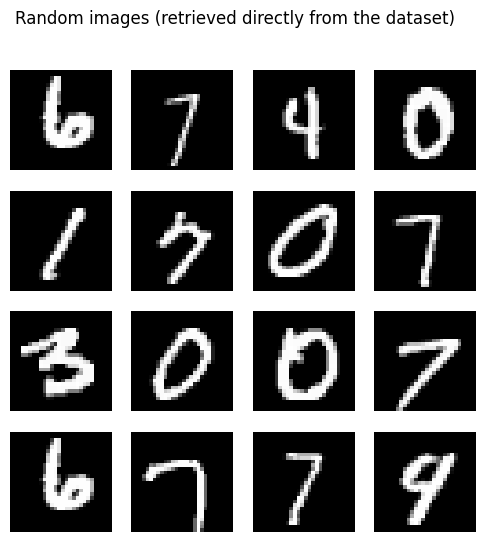

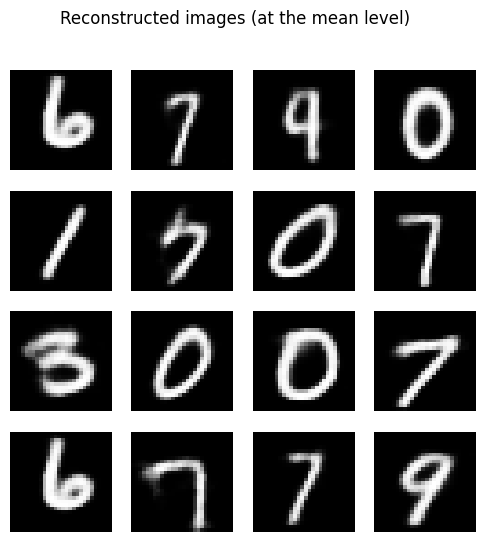

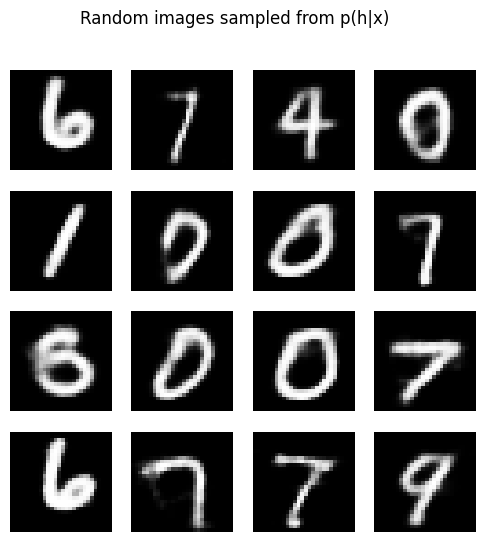

In [ ]:
# Load and plot the training dataset.
data = np.load(r"/content/drive/My Drive/UNSW - Foundation of Cybersecurity/pcp/code/data/mnist-sampled-N10000.npz")
data_img = data.get(data.files[0]) / 255.0
np.random.seed(5560)
idx_sampled = np.random.choice(data_img.shape[0], size=4*4) # sample some random images to be attacked


# Plot images in a grid
def show_grid_images(X, width=4, height=4, title=''):
    f, ax = plt.subplots(width, height, figsize=(6, 6))
    img = 0
    for i in range(width):
        for j in range(height):
            ax[i, j].imshow(X[img].reshape(28, 28), cmap='gray', aspect='auto')
            ax[i, j].axis('off')
            img += 1
    f.suptitle(title)


# Plot the raw images
show_grid_images(data_img[idx_sampled], title='Random images (retrieved directly from the dataset)')


# Plot the reconstructed images (at mean level)
data_recon = decoder(torch.Tensor(h[idx_sampled])).detach().numpy()
show_grid_images(data_recon, title='Reconstructed images (at the mean level)')


# Plot random images drawn from the standard Gaussian distribution
z = torch.randn(h[idx_sampled].shape) # Sampled from N(0, I)
X = torch.Tensor(data_img[idx_sampled]).reshape(len(idx_sampled), 1, 28, 28) # subsample dataset
f_x = encoder(X) # encoding
mu = f_x[:, :10] # compute mean level
var = torch.exp(f_x[:, 10:]) # compute diagonal variances
h_random = mu + 1.5*torch.sqrt(var)*z # reparametrization trick
data_random = decoder(h_random).detach().numpy() # decoding
show_grid_images(data_random, title='Random images sampled from p(h|x)')

(-0.5, 27.5, 27.5, -0.5)

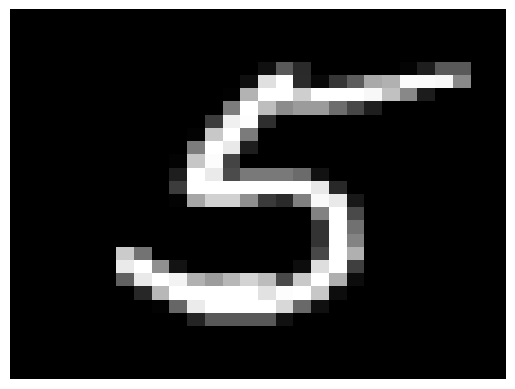

In [ ]:
# We fix an image different from the sampled images
idx_target = 80
plt.imshow(data_img[idx_target].reshape(28, 28), cmap='gray', aspect='auto')
plt.axis('off')

In [ ]:
# VAE attack - input space
# objective function
li_delta = []

def obj_attack(delta, x, x_target, C):
    h_temp = encoder(x + delta)[:, :10]
    f1 = torch.sum((decoder(h_temp) - x_target) **2)
    f2 = C*torch.sqrt(torch.sum(delta ** 2))
    return f1 + f2

for i in range(X.shape[0]):
    opt_delta = None
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    delta_init = 0.1 * (2 * torch.rand(28, 28) - 1) # initialize a perturbation i.e. direction.
    delta = nn.Parameter(delta_init.to(device), requires_grad=True)

    optimizer = optim.LBFGS([delta], lr=1, history_size=10, max_iter=4, line_search_fn="strong_wolfe") # L-BFGS optimizer

    start_timestamp = time.time()
    epoch = 0
    min_loss = torch.inf
    li_loss = []
    max_iter = 1000
    C = 40 # C controls for the norm (size) of perturbation
    x = X[i, :] # select a raw image
    x_hat = torch.Tensor(data_img[idx_target].reshape(28, 28)) # target image, very different from x
    delta_min = -0.15 # lower limit of delta
    delta_max = 0.15 # upper limit of delta

    def closure():
        # Closure for L-BFGS in which multiple evaluation takes place
        optimizer.zero_grad()
        loss = obj_attack(delta, x, x_hat, C)
        loss.backward()
        return loss

    while epoch < max_iter:
        optimizer.step(closure)
        current_loss = obj_attack(delta, x, x_hat, C).item()
        li_loss.append(current_loss)

        # save best loss and best solution
        if current_loss < min_loss:
            min_loss = current_loss
            opt_delta = delta.detach().clone()

        elapsed_minutes = (time.time() - start_timestamp) / 60
        print(f'Epoch: {epoch} | elapsed_minutes: {elapsed_minutes} | loss: {li_loss[-1]}')
        epoch += 1

        with torch.no_grad():
            delta.clamp_(delta_min , delta_max)

    li_delta.append(opt_delta)

Streaming output truncated to the last 5000 lines.
Epoch: 0 | elapsed_minutes: 0.00040051937103271487 | loss: 124.70398712158203
Epoch: 1 | elapsed_minutes: 0.0007909019788106282 | loss: 113.0501708984375
Epoch: 2 | elapsed_minutes: 0.0011998216311136882 | loss: 112.19218444824219
Epoch: 3 | elapsed_minutes: 0.0016091823577880859 | loss: 111.96202087402344
Epoch: 4 | elapsed_minutes: 0.002060274283091227 | loss: 111.85723876953125
Epoch: 5 | elapsed_minutes: 0.0024764100710550946 | loss: 111.7387924194336
Epoch: 6 | elapsed_minutes: 0.00295716921488444 | loss: 111.4304428100586
Epoch: 7 | elapsed_minutes: 0.0034719387690226237 | loss: 110.35306549072266
Epoch: 8 | elapsed_minutes: 0.003871436913808187 | loss: 109.03607940673828
Epoch: 9 | elapsed_minutes: 0.004315702120463053 | loss: 108.25708770751953
Epoch: 10 | elapsed_minutes: 0.004753386974334717 | loss: 107.90320587158203
Epoch: 11 | elapsed_minutes: 0.005143443743387858 | loss: 107.75798797607422
Epoch: 12 | elapsed_minutes: 0.0

Text(0.5, 0.98, 'Decoded image ($g(\\mu(x + \\delta))$ with $C$=40)')

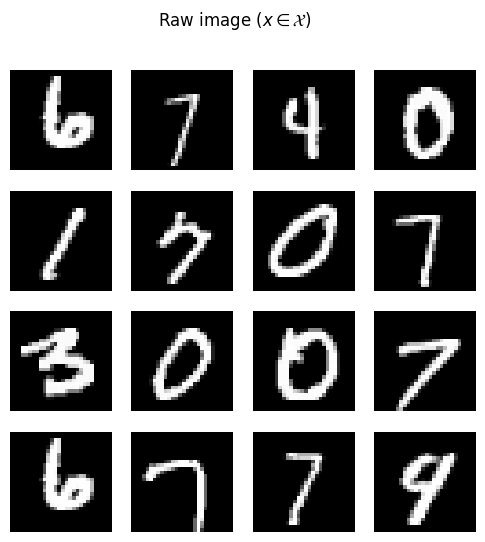

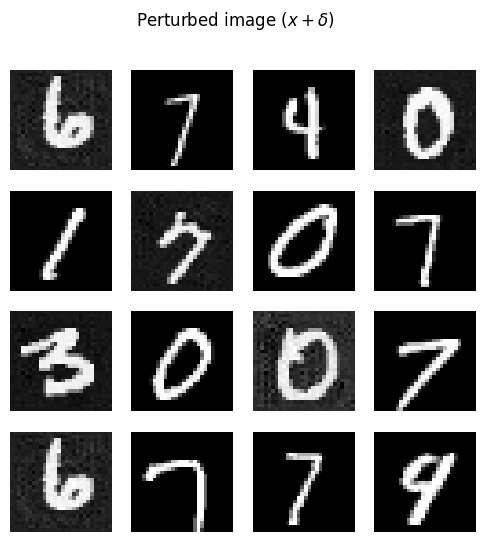

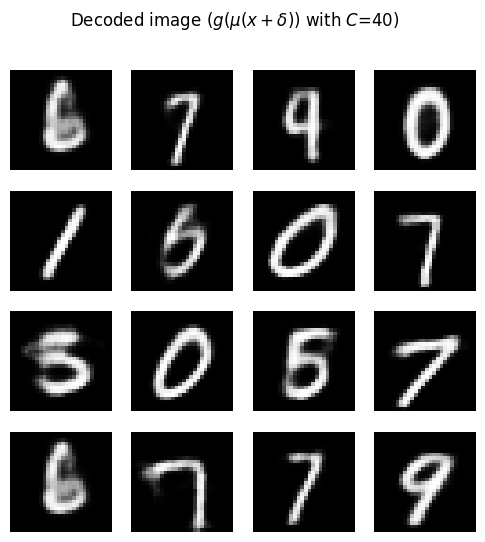

In [ ]:
# Plot images in a grid
width = 4
height = 4
f1, ax1 = plt.subplots(width, height, figsize=(6, 6))
f2, ax2 = plt.subplots(width, height, figsize=(6, 6))
f3, ax3 = plt.subplots(width, height, figsize=(6, 6))

num = 0
for i in range(width):
    for j in range(height):
        x_np = X[num, :].detach().numpy().reshape(28, 28)
        x_perturbed_np = (X[num, :] + li_delta[num]).detach().numpy().reshape(28, 28)
        x_recon_np = decoder(encoder(X[num, :] + li_delta[num])[:, :10]).detach().numpy().reshape(28, 28)

        ax1[i, j].imshow(x_np, cmap='gray', aspect='auto')
        ax2[i, j].imshow(x_perturbed_np, cmap='gray', aspect='auto')
        ax3[i, j].imshow(x_recon_np, cmap='gray', aspect='auto')

        ax1[i, j].axis('off')
        ax2[i, j].axis('off')
        ax3[i, j].axis('off')
        num += 1

f1.suptitle('Raw image ($x \in \mathcal{X}$)')
f2.suptitle('Perturbed image ($x+\delta$)')
f3.suptitle('Decoded image ($g(\mu(x + \delta))$ with $C$=40)')